# [**Classification**] Pytorch를 사용해서 Titanic 데이터 분류 모델 만들기


## **1.환경준비**

### (1) 라이브러리 Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder

In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam

### (2) 필요 함수 생성

* 딥러닝을 위한 데이터로더 만들기

In [3]:
def make_DataSet(x_train, x_val, y_train, y_val, batch_size = 32) :

    # 데이터 텐서로 변환
    x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)  # long = int64
    x_val_tensor = torch.tensor(x_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.long)

    # TensorDataset 생성 : 텐서 데이터셋으로 합치기
    train_dataset = TensorDataset(x_train_tensor, y_train_tensor)

    # DataLoader 생성
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle = True)

    return train_loader, x_val_tensor, y_val_tensor

* 학습을 위한 함수

In [4]:
def train(dataloader, model, loss_fn, optimizer, device):
    size = len(dataloader.dataset)                  # 전체 데이터셋의 크기
    num_batches = len(dataloader)                   # 배치 크기
    tr_loss = 0
    model.train()                                   # 훈련 모드로 설정(드롭아웃 및 배치 정규화와 같은 계층을 훈련 모드로 변경)
    for batch, (X, y) in enumerate(dataloader):     # batch : 현재 배치 번호, (X, y) : 입력 데이터와 레이블
        X, y = X.to(device), y.to(device)           # X.to(device), y.to(device): 입력 데이터와 레이블을 지정된 장치(device, CPU 또는 GPU)로 이동

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        tr_loss += loss

        # Backpropagation
        loss.backward()             # 역전파를 통해 모델의 각 파라미터에 대한 손실의 기울기를 계산
        optimizer.step()            # 옵티마이저가 계산된 기울기를 사용하여 모델의 파라미터를 업데이트
        optimizer.zero_grad()       # 옵티마이저의 기울기 값 초기화. 기울기가 누적되는 것 방지

    tr_loss /= num_batches          # 모든 배치에서의 loss 평균

    return tr_loss.item()

* 검증을 위한 함수

In [5]:
def evaluate(x_val_tensor, y_val_tensor, model, loss_fn, device):
    model.eval()                        # 모델을 평가 모드로 설정

    with torch.no_grad():               # 평가 과정에서 기울기를 계산하지 않도록 설정(메모리 사용을 줄이고 평가 속도를 높입니다.)
        x, y = x_val_tensor.to(device), y_val_tensor.to(device)
        pred = model(x)
        eval_loss = loss_fn(pred, y).item()    # 예측 값 pred와 실제 값 y 사이의 손실 계산

    return eval_loss, pred

* 학습곡선

In [6]:
def dl_learning_curve(tr_loss_list, val_loss_list):

    epochs = list(range(1, len(tr_loss_list)+1))
    plt.plot(epochs, tr_loss_list, label='train_err', marker = '.')
    plt.plot(epochs, val_loss_list, label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

### (3) device 준비(cpu or gpu)

In [7]:
# cpu 혹은 gpu 사용
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


### (4) 데이터로딩

In [8]:
path = "https://raw.githubusercontent.com/suku-7/dl_pytorch-study_20250419/refs/heads/main/titanic_train.csv"
df = pd.read_csv(path)
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


[데이터 컬럼 설명 (데이터 파일명: titanic_train.csv)]
- PassengerId : 승객 고유 ID
- Pclass : 선실 등급 (1, 2, 3등급)
- Name : 승객 이름
- Sex : 성별
- Age : 나이
- SibSp : 함께 탑승한 형제자매/배우자 수
- Parch : 함께 탑승한 부모/자녀 수
- Ticket : 티켓 번호
- Fare : 운임 요금
- Cabin : 선실 번호
- Embarked : 탑승 항구 (C: Cherbourg, Q: Queenstown, S: Southampton)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


## **2.데이터 준비**

### (1) 데이터 준비

In [10]:
# 결측치 확인 및 제거
df.isnull().sum()

,0
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,177
SibSp,0
Parch,0
Ticket,0
Fare,0


In [11]:
# 결측치가 너무 많은 Cabin 컬럼은 삭제, 나머지 Age, Embarked는 결측치 제거
df = df.drop('Cabin', axis=1)
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 712 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  712 non-null    int64  
 1   Survived     712 non-null    int64  
 2   Pclass       712 non-null    int64  
 3   Name         712 non-null    object 
 4   Sex          712 non-null    object 
 5   Age          712 non-null    float64
 6   SibSp        712 non-null    int64  
 7   Parch        712 non-null    int64  
 8   Ticket       712 non-null    object 
 9   Fare         712 non-null    float64
 10  Embarked     712 non-null    object 
dtypes: float64(2), int64(5), object(4)
memory usage: 66.8+ KB


In [12]:
# 데이터 확인
df.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C


In [13]:
# 데이터를 확인하고, 불필요해 보이는 컬럼을 제거
# PassengerId(승객 고유 ID), Name(승객 이름), SibSp(함께 탑승한 형제자매/배우자 수), Parch(함께 탑승한 부모/자녀 수), Ticket(티켓 번호)
df = df.drop(['PassengerId', 'Name', 'SibSp', 'Parch', 'Ticket'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 712 entries, 0 to 890
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  712 non-null    int64  
 1   Pclass    712 non-null    int64  
 2   Sex       712 non-null    object 
 3   Age       712 non-null    float64
 4   Fare      712 non-null    float64
 5   Embarked  712 non-null    object 
dtypes: float64(2), int64(2), object(2)
memory usage: 38.9+ KB


### (2) 원핫 인코딩

In [14]:
obj_cols = df.select_dtypes('object').columns
df = pd.get_dummies(data=df, columns=obj_cols, drop_first=True)
df_preset = df.copy()

### (3) 데이터분할

In [15]:
# 데이터 분할
features = df_preset.drop('Survived', axis=1)
target = df_preset['Survived']

In [16]:
type(target)

pandas.core.series.Series

In [17]:
target

,Survived
0,0
1,1
2,1
3,1
4,0
...,...
885,0
886,0
887,1
889,1


In [18]:
x_train, x_valid, y_train, y_valid = train_test_split(features, target.values, test_size=0.2, random_state = 42, stratify=target.values)

### (4) Scaling

In [19]:
mms = MinMaxScaler()
x_train = mms.fit_transform(x_train)
x_valid = mms.transform(x_valid)

## **3.모델링1**

### (1) 딥러닝을 위한 준비작업

* make_DataLoader

In [20]:
train_loader, x_valid_ts, y_valid_ts = make_DataSet(x_train, x_valid, y_train, y_valid, 32)

In [21]:
# 첫번째 배치만 로딩해서 살펴보기
for x, y in train_loader:
    print(f"Shape of x [rows, columns]: {x.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of x [rows, columns]: torch.Size([32, 6])
Shape of y: torch.Size([32]) torch.int64


### (2) 모델 선언

In [22]:
n_feature = x_train.shape[-1]
n_class = 2

# 모델 구조 설계
model = nn.Sequential(nn.Linear(n_feature, 64),
                      nn.ReLU(),
                      nn.Dropout(p=0.2),
                      nn.Linear(64, 32),
                      nn.ReLU(),
                      nn.Dropout(p=0.2),
                      nn.Linear(32, 16),
                      nn.ReLU(),
                      nn.Dropout(p=0.2),
                      nn.Linear(16, n_class)
        ).to(device)

print(model)

Sequential(
  (0): Linear(in_features=6, out_features=64, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=64, out_features=32, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.2, inplace=False)
  (6): Linear(in_features=32, out_features=16, bias=True)
  (7): ReLU()
  (8): Dropout(p=0.2, inplace=False)
  (9): Linear(in_features=16, out_features=2, bias=True)
)


* Loss function과 Optimizer

In [23]:
loss_fn = nn.CrossEntropyLoss()       # Cross Entropy : 이 손실 함수는 내부에 SoftMax 연산이 포함(출력층 활성화함수 지정 안함)
optimizer = Adam(model.parameters(), lr=0.001)

### (3) 학습

In [24]:
epochs = 100
tr_loss_list, val_loss_list, val_acc_list = [], [], []

# early stopping을 위한 변수 설정 ----------------
patience = 5
best_loss = float('inf')  # 초기값을 무한대로 설정
counter = 0
# ------------------------------------------------

for t in range(epochs):
    tr_loss = train(train_loader, model, loss_fn, optimizer, device)
    val_loss,_= evaluate(x_valid_ts, y_valid_ts, model, loss_fn, device)

    # 리스트에 추가
    tr_loss_list.append(tr_loss)     # train - CrossEntropy
    val_loss_list.append(val_loss)   # val - CrossEntropy

    print(f"Epoch {t+1}, train loss : {tr_loss:4f}, val loss : {val_loss:4f}")

    # early stopping 확인 -------------------
    if val_loss > best_loss:
            counter += 1
            print(f'--> early stopping status, best_loss : {best_loss:4f}, counter : {counter}')

    else:
        best_loss = val_loss
        counter = 0
        torch.save(model.state_dict(), 'best_model.pt')  # 💾 best 모델의 파라미터 저장
        print(f"✔️ Best model saved at epoch {t+1} with val loss: {best_loss:.4f}")  # ✅ 저장 메시지

    # 조기 종료 조건 확인
    if counter >= patience:
        print("Early Stopping!")
        break
    # ----------------------------------------

Epoch 1, train loss : 0.684033, val loss : 0.671764
✔️ Best model saved at epoch 1 with val loss: 0.6718
Epoch 2, train loss : 0.661757, val loss : 0.644872
✔️ Best model saved at epoch 2 with val loss: 0.6449
Epoch 3, train loss : 0.628331, val loss : 0.607681
✔️ Best model saved at epoch 3 with val loss: 0.6077
Epoch 4, train loss : 0.588117, val loss : 0.564832
✔️ Best model saved at epoch 4 with val loss: 0.5648
Epoch 5, train loss : 0.553768, val loss : 0.525060
✔️ Best model saved at epoch 5 with val loss: 0.5251
Epoch 6, train loss : 0.531024, val loss : 0.502017
✔️ Best model saved at epoch 6 with val loss: 0.5020
Epoch 7, train loss : 0.516926, val loss : 0.484379
✔️ Best model saved at epoch 7 with val loss: 0.4844
Epoch 8, train loss : 0.490279, val loss : 0.472657
✔️ Best model saved at epoch 8 with val loss: 0.4727
Epoch 9, train loss : 0.472050, val loss : 0.466412
✔️ Best model saved at epoch 9 with val loss: 0.4664
Epoch 10, train loss : 0.468325, val loss : 0.459847
✔️

* 학습 곡선

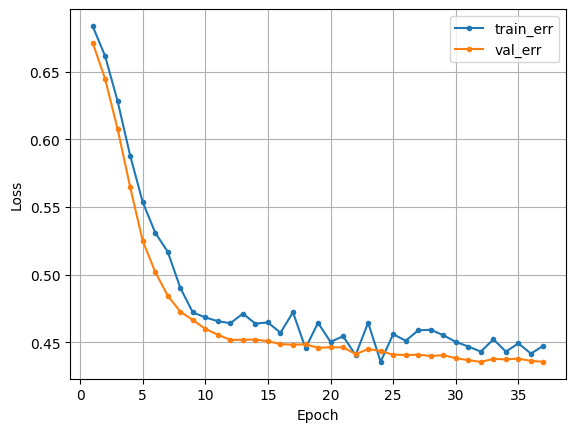

In [25]:
dl_learning_curve(tr_loss_list, val_loss_list)

### (4) 모델 평가

In [26]:
# 1. 예측결과
_, pred = evaluate(x_valid_ts, y_valid_ts, model, loss_fn, device)

# 다중 분류의 예측 결과는 2차원 구조
pred.numpy()[:5]

array([[-0.9408737 ,  1.2094767 ],
       [ 0.8632014 , -0.45692167],
       [ 0.88733274, -0.47826725],
       [ 0.21624678,  0.17409986],
       [ 1.0756032 , -0.5335933 ]], dtype=float32)

In [27]:
# 2. softmax로 변환
pred = nn.functional.softmax(pred, dim=1)
pred[:5]

tensor([[0.1043, 0.8957],
        [0.7892, 0.2108],
        [0.7967, 0.2033],
        [0.5105, 0.4895],
        [0.8333, 0.1667]])

In [28]:
# 3. 가장 큰 값의 인덱스
pred = np.argmax(pred.numpy(), axis = 1)
pred[:5]

array([1, 0, 0, 0, 0])

* confusion matrix

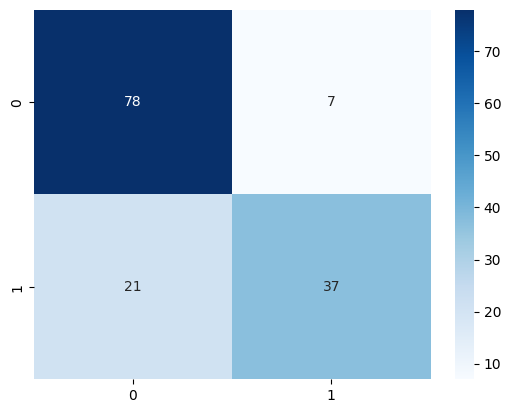

In [29]:
cm = confusion_matrix(y_valid_ts.numpy(), pred)
sns.heatmap(data=cm, annot=True, fmt='d', cmap='Blues')
plt.show()

* classification_report

In [30]:
print(classification_report(y_valid_ts.numpy(), pred))

              precision    recall  f1-score   support

           0       0.79      0.92      0.85        85
           1       0.84      0.64      0.73        58

    accuracy                           0.80       143
   macro avg       0.81      0.78      0.79       143
weighted avg       0.81      0.80      0.80       143

